In [1]:
!pip install tensorflow
!pip install gym

In [ ]:
# #remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!pip install gym[box2d]
!pip install tf-agents

In [3]:
import os
from absl import logging
import time
import numpy as np
import gym
import tensorflow as tf

from tf_agents.environments import wrappers, gym_wrapper, tf_py_environment
from tf_agents.train.utils import spec_utils
from tf_agents.agents.sac import sac_agent
from tf_agents.policies.policy_saver import PolicySaver
from tf_agents.networks import network, actor_distribution_rnn_network, normal_projection_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import random_tf_policy
from tf_agents.metrics import tf_metrics

from CriticRnnNetwork import CriticRnnNetwork
from penalty_wrappers import NegRewardPenalty, SpeedPenalty
from CNNPreprocessingLayer import CNNPreprocessingLayer

In [9]:
!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1089'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1089'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [8]:
def _create_env(env):
    return gym_wrapper.GymWrapper(
    env,
    discount=1.,
    auto_reset=True,)

def create_env(verbose=0):
    return _create_env(gym.make("CarRacing-v0",verbose=verbose))

def create_train_env(action_repeat=1):
    env = gym.make("CarRacing-v0",verbose=0)
    env =  _create_env(NegRewardPenalty(env))
    if action_repeat > 1:
        env = wrappers.ActionRepeat(env, action_repeat)
    return tf_py_environment.TFPyEnvironment(env)

def create_eval_env():
   return tf_py_environment.TFPyEnvironment(create_env())

def create_train_eval_envs(action_repeat=1):
    env = gym.make("CarRacing-v0",verbose=0)
    eval_env = _create_env(env)
    env =  _create_env(SpeedPenalty(NegRewardPenalty(env)))
    if action_repeat > 1:
        env = wrappers.ActionRepeat(env, action_repeat)
    return env, eval_env

In [11]:
def normal_projection_net(action_spec,
                          init_means_output_factor=0.1):
  return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      std_transform=sac_agent.std_clip_transform,
      scale_distribution=True)

In [12]:
def train_eval(
    root_dir,
    experiment_name,  # experiment name
    num_iterations=int(1e3),
    actor_fc_layers=(20,),
    critic_joint_fc_layers=(20,),
    action_fc_layer_params= (8,),
    actor_lstm_size=(40,),  # lstm size for actor
    critic_lstm_size=(40,),  # lstm size for critic
    actor_output_fc_layers=(32,),  # lstm output
    critic_output_fc_layers=(32,),  # lstm output
    # Params for collect
    initial_collect_steps=1000,
    collect_steps_per_iteration=1,
    replay_buffer_capacity=int(1e4),
    # Params for target update
    target_update_tau=0.005,
    target_update_period=1,
    train_steps_per_iteration=3,
    batch_size=64,
    sequence_length=8,  # number of timesteps to train model
    actor_learning_rate=2e-4,
    critic_learning_rate=2e-4,
    alpha_learning_rate=2e-4,
    td_errors_loss_fn=tf.losses.mean_squared_error,
    gamma=0.99,
    reward_scale_factor=.5,
    action_repeat=2,
    # Params for eval
    num_eval_episodes=2,
    eval_interval=500,
    # Params for summaries and logging
    checkpoint_interval=600,
    rb_checkpoint_interval = 900,
    log_interval=300,
    summary_interval=500,
    summaries_flush_secs=10,
    debug_summaries=False,
    summarize_grads_and_vars=False):

  # Get train and eval direction
  root_dir = os.path.expanduser(root_dir)
  root_dir = os.path.join(root_dir, experiment_name)

  #Get summary writers
  summary_writer = tf.summary.create_file_writer(
      root_dir, flush_millis=summaries_flush_secs * 1000)
  summary_writer.set_as_default()

  # Eval metrics
  eval_metrics = [
      tf_metrics.AverageReturnMetric(
        name='AverageReturnEvalPolicy', buffer_size=num_eval_episodes),
      tf_metrics.AverageEpisodeLengthMetric(
        name='AverageEpisodeLengthEvalPolicy',
        buffer_size=num_eval_episodes),
  ]

  global_step = tf.compat.v1.train.get_or_create_global_step()

  # Whether to record for summary
  with tf.summary.record_if(lambda: tf.math.equal(global_step % summary_interval, 0)):
    tf_env = create_train_env(action_repeat=action_repeat)
    eval_tf_env = create_eval_env()

    observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(tf_env))
    preprocessing_layers = CNNPreprocessingLayer(8)



    actor_distribution_rnn_net = actor_distribution_rnn_network.ActorDistributionRnnNetwork(
        observation_spec,
        action_spec,
        preprocessing_layers=preprocessing_layers,
        input_fc_layer_params=actor_fc_layers,
        lstm_size=actor_lstm_size,
        output_fc_layer_params=actor_output_fc_layers,
        continuous_projection_net=normal_projection_net
    )
    

    critic_rnn_net = CriticRnnNetwork(
        (observation_spec, action_spec),
        preprocessing_layer=preprocessing_layers,
        action_fc_layer_params=action_fc_layer_params,
        joint_fc_layer_params=critic_joint_fc_layers,
        lstm_size=critic_lstm_size,
        output_fc_layer_params=critic_output_fc_layers)

    tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_distribution_rnn_net,
        critic_network=critic_rnn_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=global_step)


    tf_agent.initialize()
    
    # Get replay buffer
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=1,  # No parallel environments
        max_length=replay_buffer_capacity)

    replay_observer = [replay_buffer.add_batch]

    # Train metrics
    env_steps = tf_metrics.EnvironmentSteps()
    average_return = tf_metrics.AverageReturnMetric(
        buffer_size=num_eval_episodes,
        batch_size=tf_env.batch_size)
    train_metrics = [
        tf_metrics.NumberOfEpisodes(),
        env_steps,
        average_return,
        tf_metrics.AverageEpisodeLengthMetric(
            buffer_size=num_eval_episodes,
            batch_size=tf_env.batch_size),
    ]

    # Get policies
    # eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
    eval_policy = tf_agent.policy
    initial_collect_policy = random_tf_policy.RandomTFPolicy(
        time_step_spec, action_spec)
    collect_policy = tf_agent.collect_policy

    # Checkpointers
    train_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(root_dir, 'train'),
        agent=tf_agent,
        global_step=global_step,
        metrics=metric_utils.MetricsGroup(train_metrics, 'train_metrics'),
        max_to_keep=2)
    policy_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(root_dir, 'policy'),
        policy=eval_policy,
        global_step=global_step,
        max_to_keep=2)
    rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(root_dir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)
    train_checkpointer.initialize_or_restore()
    rb_checkpointer.initialize_or_restore()
    
    # Collect driver
    initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        tf_env,
        initial_collect_policy,
        observers=replay_observer + train_metrics,
        num_steps=initial_collect_steps)

    collect_driver = dynamic_step_driver.DynamicStepDriver(
        tf_env,
        collect_policy,
        observers=replay_observer + train_metrics,
        num_steps=collect_steps_per_iteration)
    

    # Optimize the performance by using tf functions
#     initial_collect_driver.run = common.function(initial_collect_driver.run)
    collect_driver.run = common.function(collect_driver.run)
    tf_agent.train = common.function(tf_agent.train)

    # Collect initial replay data.
    logging.info('%d replay_buffer num_frames', replay_buffer.num_frames())
    if (env_steps.result() == 0 or replay_buffer.num_frames() == 0):
      logging.info(
          'Initializing replay buffer by collecting experience for %d steps'
          'with a random policy.', initial_collect_steps)
      initial_collect_driver.run()
      logging.info('Initializing replay buffer ended')
    

    # Dataset generates trajectories with shape [Bxslx...]
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=sequence_length + 1).prefetch(3)
    iterator = iter(dataset)


    # Get train step
    def train_step():
      experience, _ = next(iterator)
      return tf_agent.train(experience)
    train_step = common.function(train_step)


    # Training initializations
    time_step = None
    policy_state = None
    time_acc = 0
    env_steps_before = env_steps.result().numpy()

    # Start training
    for iteration in range(num_iterations):
      start_time = time.time()


      # Run collect
      time_step, policy_state = collect_driver.run(time_step=time_step,policy_state=policy_state)


        # Train an iteration
      for _ in range(train_steps_per_iteration):
        train_step()

      time_acc += time.time() - start_time

      # Log training information
      global_step_val = global_step.numpy()
      if global_step_val % log_interval == 0:
        logging.info('env steps = %d, average return = %f', env_steps.result(),
                     average_return.result())
        env_steps_per_sec = (env_steps.result().numpy() -
                             env_steps_before) / time_acc
        logging.info('%.3f env steps/sec', env_steps_per_sec)
        tf.summary.scalar(
            name='env_steps_per_sec',
            data=env_steps_per_sec,
            step=env_steps.result())
        time_acc = 0
        env_steps_before = env_steps.result().numpy()

      # Get training metrics
      for train_metric in train_metrics:
        train_metric.tf_summaries(train_step=env_steps.result())

      # Evaluation
      if global_step_val % eval_interval == 0:
        eval_time = time.time()
        with Display(visible=False, size=(1400, 900)):
          results = metric_utils.eager_compute(
              eval_metrics,
              eval_tf_env,
              eval_policy,
              num_episodes=num_eval_episodes,
              train_step=env_steps.result(),
              summary_writer=summary_writer,
              summary_prefix='Eval',
              use_function = True
            )
          metric_utils.log_metrics(eval_metrics)
          eval_episode_per_sec = (time.time() - eval_time)/num_eval_episodes
          logging.info('%.3f eval episode/sec' % eval_episode_per_sec)
          eval_tf_env.pyenv.envs[0].close()
      if global_step_val % checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step_val)
        policy_checkpointer.save(global_step=global_step_val)
      if global_step_val % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step_val)


    global_step_val = global_step.numpy()    
    train_checkpointer.save(global_step=global_step_val)
    policy_checkpointer.save(global_step=global_step_val)
    rb_checkpointer.save(global_step=global_step_val)
    tf_env.pyenv.envs[0].close()  
    saver = PolicySaver(tf_agent.policy)
    saver.save('eval_policy')
  return tf_agent.policy

In [16]:
from tf_agents.eval import metric_utils
from absl import logging
from tf_agents.metrics import tf_metrics
import functools
tf.compat.v1.enable_v2_behavior()
logging.set_verbosity(logging.INFO)
policy,replay_buffer = train_eval('log', 'EX3',num_iterations=5000)


Instructions for updating:
The `param_static_shapes` method of `tfd.Distribution` is deprecated; use `parameter_properties` instead.
Instructions for updating:
The `param_shapes` method of `tfd.Distribution` is deprecated; use `parameter_properties` instead.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
INFO:absl:Checkpoint available: TEST_DIR/EX3/train/ckpt-277200
INFO:absl:Checkpoint available: TEST_DIR/EX3/policy/ckpt-277200
INFO:absl:Checkpoint available: TEST_DIR/EX3/replay_buffer/ckpt-277200
INFO:absl:10000 replay_buffer num_frames


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
INFO:absl:env steps = 93500, average return = 16.702131
INFO:absl:3.404 env steps/sec
INFO:absl: 
		 AverageReturnEvalPolicy = 156.69773864746094
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:6.977 eval episode/sec
INFO:absl:env steps = 93600, average return = 16.702131
INFO:absl:5.242 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-277800
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-277800
INFO:absl:env steps = 93700, average return = 95.875526
INFO:absl:5.370 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-278100
INFO:absl:env steps = 93800, average return = 95.875526
INFO:absl:5.274 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-278400
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-278400
INFO:absl:env steps = 93900, average return = 95.875526
INFO:absl:5.352 env steps/sec
INFO:absl:env steps = 94000, average retur

INFO:absl: 
		 AverageReturnEvalPolicy = 97.78831481933594
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:7.211 eval episode/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-283500
INFO:absl:env steps = 95600, average return = 141.342117
INFO:absl:5.195 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-283800
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-283800
INFO:absl:env steps = 95700, average return = 144.728073
INFO:absl:5.324 env steps/sec
INFO:absl:env steps = 95800, average return = 144.728073
INFO:absl:5.280 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-284400
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-284400
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-284400
INFO:absl:env steps = 95900, average return = 144.728073
INFO:absl:5.287 env steps/sec
INFO:absl:env steps = 96000, average return = 121.768585
INFO:absl:5.251 env steps/sec


INFO:absl: 
		 AverageReturnEvalPolicy = 135.3138427734375
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:6.905 eval episode/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-285000
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-285000
INFO:absl:env steps = 96100, average return = 121.768585
INFO:absl:5.225 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-285300
INFO:absl:env steps = 96200, average return = 121.768585
INFO:absl:4.525 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-285600
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-285600
INFO:absl:env steps = 96300, average return = 110.376785
INFO:absl:5.179 env steps/sec
INFO:absl:env steps = 96400, average return = 60.740047
INFO:absl:5.274 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-286200
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-286200
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-286200
INFO:absl:env steps = 96500

INFO:absl: 
		 AverageReturnEvalPolicy = 151.260009765625
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:7.246 eval episode/sec
INFO:absl:env steps = 96600, average return = 98.934258
INFO:absl:5.243 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-286800
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-286800
INFO:absl:env steps = 96700, average return = 98.934258
INFO:absl:5.440 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-287100
INFO:absl:env steps = 96800, average return = 111.421059
INFO:absl:5.287 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-287400
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-287400
INFO:absl:env steps = 96900, average return = 111.421059
INFO:absl:5.296 env steps/sec
INFO:absl:env steps = 97000, average return = 142.981873
INFO:absl:5.280 env steps/sec


INFO:absl: 
		 AverageReturnEvalPolicy = 104.00981140136719
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:7.038 eval episode/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-288000
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-288000
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-288000
INFO:absl:env steps = 97100, average return = 142.981873
INFO:absl:5.177 env steps/sec
INFO:absl:env steps = 97200, average return = 75.434402
INFO:absl:5.307 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-288600
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-288600
INFO:absl:env steps = 97300, average return = 75.434402
INFO:absl:5.287 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-288900
INFO:absl:env steps = 97400, average return = 75.434402
INFO:absl:5.322 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-289200
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-289200
INFO:absl:env steps = 97500,

INFO:absl: 
		 AverageReturnEvalPolicy = 111.53699493408203
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:7.252 eval episode/sec
INFO:absl:env steps = 97600, average return = 199.575470
INFO:absl:5.299 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-289800
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-289800
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-289800
INFO:absl:env steps = 97700, average return = 199.575470
INFO:absl:5.340 env steps/sec
INFO:absl:env steps = 97800, average return = 199.575470
INFO:absl:5.380 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-290400
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-290400
INFO:absl:env steps = 97900, average return = 224.843384
INFO:absl:5.379 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-290700
INFO:absl:env steps = 98000, average return = 224.843384
INFO:absl:5.332 env steps/sec


INFO:absl: 
		 AverageReturnEvalPolicy = 132.34326171875
		 AverageEpisodeLengthEvalPolicy = 1000.0
INFO:absl:7.096 eval episode/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-291000
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-291000
INFO:absl:env steps = 98100, average return = 212.727020
INFO:absl:5.329 env steps/sec
INFO:absl:env steps = 98200, average return = 212.727020
INFO:absl:5.367 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-291600
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-291600
INFO:absl:Saved checkpoint: TEST_DIR/EX3/replay_buffer/ckpt-291600
INFO:absl:env steps = 98300, average return = 67.664658
INFO:absl:5.281 env steps/sec
INFO:absl:env steps = 98400, average return = 67.664658
INFO:absl:5.344 env steps/sec
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-292200
INFO:absl:Saved checkpoint: TEST_DIR/EX3/policy/ckpt-292200
INFO:absl:Saved checkpoint: TEST_DIR/EX3/train/ckpt-292200
INFO:absl:Saved checkpoint: TEST_DIR/E

INFO:tensorflow:Assets written to: eval_policy/assets


INFO:tensorflow:Assets written to: eval_policy/assets


In [21]:
import base64
import imageio
import IPython
import cv2

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [26]:
num_episodes = 1
video_filename = 'CarRacing3.mp4'
py_env = create_env()
eval_tf_env = tf_py_environment.TFPyEnvironment(py_env)

with imageio.get_writer(video_filename, fps=60) as video:
    
    for _ in range(num_episodes):
        rr = 0.
        time_step = eval_tf_env.reset()
        policy_state = policy.get_initial_state(eval_tf_env.batch_size)
        video.append_data(py_env.render('rgb_array'))
        
        i = 0
        while not time_step.is_last():
            action_step = policy.action(time_step,policy_state)
            action = action_step.action
            time_step = eval_tf_env.step(action)
            policy_state = action_step.state
            video.append_data(py_env.render('rgb_array'))
            r = time_step.reward[0]
            rr += r
            i += 1
            if i % 100 == 0:
                print(i)
        print('reward=',rr.numpy())
py_env.close()

embed_mp4(video_filename)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


100
200
300
400
500
600
700
800
900
1000
reward= 125.00077


In [49]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
event_acc = EventAccumulator("log/EX3/", size_guidance={'tensors': 0})
_ = event_acc.Reload()

In [4]:
dfs = {}
for k in event_acc.Tags()['tensors']:
    df = pd.DataFrame([(w, s, tf.make_ndarray(t)) for w, s, t in event_acc.Tensors(k)],columns=['wall_time', 'step', k])
    dfs[k] = df.astype({k: 'float32'})

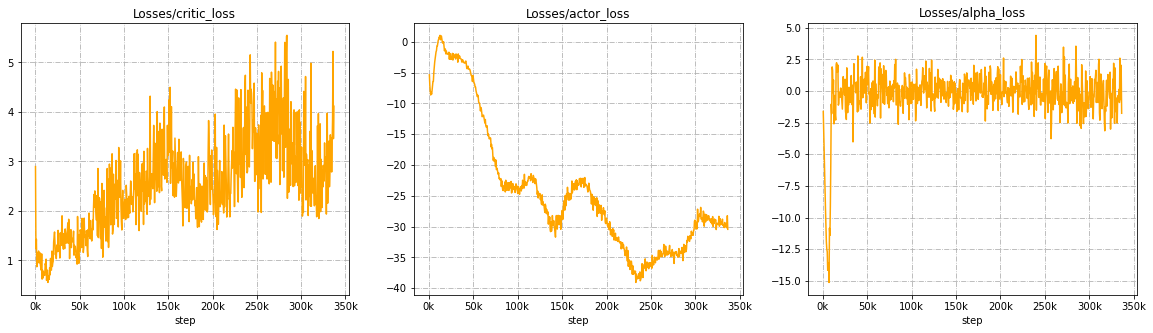

In [36]:
import matplotlib.pyplot as plt
axs = plt.subplots(1,3,figsize=(20,5))[1]
for k,ax in zip(['Losses/critic_loss', 'Losses/actor_loss', 'Losses/alpha_loss'],axs):
    dfs[k].plot(x='step',y=k,ax=ax,title=k,legend=False,color='orange')
    ax.grid(True, linestyle='-.')
    xt = ax.get_xticks()[1:-1]
    ax.set_xticks(xt)
    ax.set_xticklabels(["%dk" %(x//1000) for x in xt])


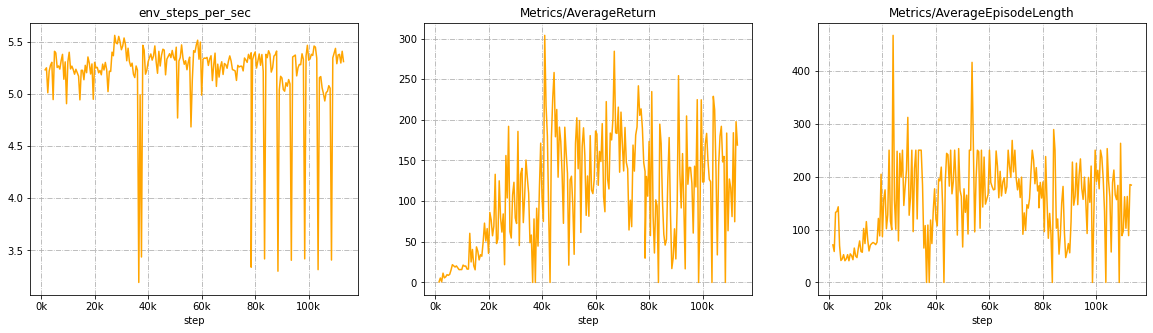

In [46]:
axs = plt.subplots(1,3,figsize=(20,5))[1]
for k,ax in zip(['env_steps_per_sec','Metrics/AverageReturn', 'Metrics/AverageEpisodeLength'],axs):
    dfs[k].plot(x='step',y=k,ax=ax,title=k,legend=False,color='orange')
    ax.grid(True, linestyle='-.')
    xt = ax.get_xticks()[1:-1]
    ax.set_xticks(xt)
    ax.set_xticklabels(["%dk" %(x//1000) for x in xt])

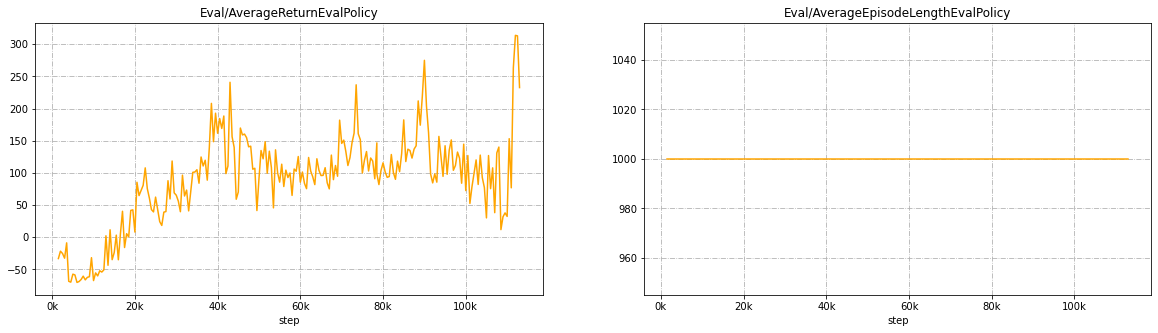

In [47]:
axs = plt.subplots(1,2,figsize=(20,5))[1]
for k,ax in zip(['Eval/AverageReturnEvalPolicy', 'Eval/AverageEpisodeLengthEvalPolicy'],axs):
    dfs[k].plot(x='step',y=k,ax=ax,title=k,legend=False,color='orange')
    ax.grid(True, linestyle='-.')
    xt = ax.get_xticks()[1:-1]
    ax.set_xticks(xt)
    ax.set_xticklabels(["%dk" %(x//1000) for x in xt])